In [67]:
import seaborn as sn
import pandas as pd
import json, os, io
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec
from gensim.models import FastText

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Masking
from tensorflow.keras.layers import Embedding, MaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Bidirectional, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import glorot_uniform, RandomUniform, lecun_uniform, Constant
from collections import OrderedDict
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPool1D
import tensorflow.keras.backend as K

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from keras_preprocessing.text import tokenizer_from_json

from imblearn.under_sampling import RandomUnderSampler
from collections import defaultdict
from sklearn.utils import shuffle


In [2]:
seeders = [123456, 789012, 345678, 901234, 567890, 123, 456, 789, 123, 456]

seed = seeders[0]

np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [53]:
method = "w2v"

In [3]:
root_path = os.path.join('..', '..', '..')
dataset = pd.read_csv(os.path.join(root_path, 'data', 'train.csv'))

In [54]:
data = dataset.sample(frac=1, random_state=seed).reset_index(drop=True)
print(data.head())
print(len(data))

    index Access Gained Attack Origin Authentication Required Availability  \
0   22328           NaN         Local            Not required     Complete   
1   39415           NaN         Local            Not required          NaN   
2   60861           NaN        Remote           Single system          NaN   
3   84364           NaN         Local            Not required      Partial   
4  177580           NaN        Remote            Not required     Complete   

           CVE ID                                        CVE Page   CWE ID  \
0   CVE-2011-4621   https://www.cvedetails.com/cve/CVE-2011-4621/      NaN   
1   CVE-2014-1738   https://www.cvedetails.com/cve/CVE-2014-1738/  CWE-264   
2  CVE-2017-14604  https://www.cvedetails.com/cve/CVE-2017-14604/   CWE-20   
3   CVE-2018-6560   https://www.cvedetails.com/cve/CVE-2018-6560/  CWE-436   
4   CVE-2016-1621   https://www.cvedetails.com/cve/CVE-2016-1621/  CWE-119   

  Complexity Confidentiality  ... parentID  \
0        Low    

In [55]:
data = data[data["project"] != "Chrome"]
print(len(data))

89145


In [56]:
data = data[["processed_func", "target"]]
data.head()

,processed_func,target
0,void account_system_time(struct task_struct *p...,0
1,static void redo_fd_request(void)\n{\n\tint dr...,0
2,cancel_filesystem_info_for_file (NautilusDirec...,0
3,"buffer_write (ProxySide *side,\n ...",0
4,virtual ~Trans16x16DCT() {}\n,0


In [57]:
data = data.dropna(subset=["processed_func"])

In [58]:
word_counts = data["processed_func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)

Maximum number of words: 15441


In [59]:
vc = data["target"].value_counts()

print(vc)

print("Percentage: ", (vc[1] / vc[0])*100, '%')

n_categories = len(vc)
print(n_categories)

target
0    83578
1     5567
Name: count, dtype: int64
Percentage:  6.660843762712676 %
2


In [60]:
train_data = pd.DataFrame(({'Text': data['processed_func'], 'Labels': data['target']}))
train_data.head()

,Text,Labels
0,void account_system_time(struct task_struct *p...,0
1,static void redo_fd_request(void)\n{\n\tint dr...,0
2,cancel_filesystem_info_for_file (NautilusDirec...,0
3,"buffer_write (ProxySide *side,\n ...",0
4,virtual ~Trans16x16DCT() {}\n,0


In [61]:
val_data = pd.read_csv(os.path.join(root_path, 'data', 'val.csv'))

val_data = val_data[val_data["project"] != "Chrome"]

val_data = pd.DataFrame(({'Text': val_data['processed_func'], 'Labels': val_data['target']}))
val_data.head()

,Text,Labels
1,int iwlagn_add_bssid_station(struct iwl_priv *...,0
2,"static int dnxhd_init_vlc(DNXHDContext *ctx, u...",0
3,void CameraService::onFirstRef()\n{\n LOG1(...,0
4,int EmbedStream::getChar() {\n if (limited &&...,0
5,"json_t *json_rpc_call(CURL *curl, const char *...",0


In [62]:
test_data = pd.read_csv(os.path.join(root_path, 'data', 'test.csv'))

test_data = test_data[test_data["project"] != "Chrome"]

test_data = pd.DataFrame(({'Text': test_data['processed_func'], 'Labels': test_data['target']}))

In [68]:
sampling = False
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["Labels"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = 4 * class_counts[class_counts.idxmin()] # int(class_counts[class_counts.idxmax()] / 2) # 2 * class_counts[class_counts.idxmin()] # class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2)  
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["Text"]).reshape(-1, 1), train_data["Labels"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["Text"]
    Y_train = train_data["Labels"]

Class distribution  Labels
0    83578
1     5567
Name: count, dtype: int64
Majority class  0
Minority class  1
Targeted number of majority class 22268
Class distribution after augmentation Labels
0    22268
1     5567
Name: count, dtype: int64


In [69]:
def stringToList(string):
    codeLinesList = []
    for line in string.split():
        codeLinesList.append(line)
    return codeLinesList

In [70]:
allTokens = []
for seq in X_train:
    listSeq = stringToList(seq)
    allTokens.append(listSeq)

X_train = allTokens

In [71]:
X_train = pd.Series(X_train)

In [72]:
allTokens = []
for seq in val_data["Text"]:
    listSeq = stringToList(seq)
    allTokens.append(listSeq)

val_data["Tokens"] = allTokens

In [73]:
allTokens = []
for seq in test_data["Text"]:
    listSeq = stringToList(seq)
    allTokens.append(listSeq)

test_data["Tokens"] = allTokens

In [74]:
# word embedding 
embeddings_index = {}
f = open('w2v_embeddings.txt', encoding="utf-8")
for line in f:    
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs   
f.close() 

dim = 100

In [75]:
concatenated_data = pd.concat([X_train, val_data["Tokens"], test_data["Tokens"]])

In [76]:
tokenizer_obj = Tokenizer()   
tokenizer_obj.fit_on_texts(concatenated_data)

tokenizer_json = tokenizer_obj.to_json()
tokenizerFile = 'w2v_tokenizer.json'

with io.open(tokenizerFile, 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

with open(tokenizerFile) as f:
    dataTokenizer = json.load(f)
    tokenizer_obj = tokenizer_from_json(dataTokenizer)

sequences = tokenizer_obj.texts_to_sequences(concatenated_data)
word_index = tokenizer_obj.word_index

lines_pad = pad_sequences(sequences, padding = 'post', maxlen = max_length)

num_words = len(word_index) + 1 # +1 for the unknown-zeros

embedding_matrix = np.zeros((num_words, dim))
for word, i in word_index.items():
    if i > num_words:
        continue
    #embedding_vector = embeddings_index.get(word)
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [77]:
# truncate sequences
max_len = 512
lines_pad = lines_pad[:, 0:512]

In [78]:
train_x = lines_pad[0:len(X_train)]
val_x = lines_pad[len(X_train):len(X_train)+len(val_data["Tokens"])]
test_x = lines_pad[len(X_train)+len(val_data["Tokens"]):len(X_train)+len(val_data["Tokens"])+len(test_data["Tokens"])]

In [79]:
# rename
x_train = train_x
x_val = val_x
x_test = test_x

In [80]:
y_train = np.array(Y_train)
y_val = np.array(val_data["Labels"])
y_test = np.array(test_data["Labels"])

In [81]:
# Evaluation functions
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

In [82]:
n_epochs = 100
patience = 10
batch_size = 64
lr = 0.001
optimizer = optimizers.Adam(learning_rate=lr)

In [83]:
# Deep Learning Models - Classifiers
def buildLstm(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(LSTM(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) # , recurrent_constraint=max_norm(3)
    model.add(LSTM(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(LSTM(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric])
    return model

def buildGru(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer)) # , recurrent_constraint=max_norm(3)
    model.add(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer))
    model.add(GRU(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric]) 
    return model

def buildBiLstm(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(Bidirectional(LSTM(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer))) # , recurrent_constraint=max_norm(3)
    model.add(Bidirectional(LSTM(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(Bidirectional(LSTM(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric]) 
    return model

def buildBiGru(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    model=Sequential()
    kernel_initializer = glorot_uniform() # glorot_uniform, RandomUniform, lecun_uniform, Constant, TruncatedNormal
    model.add(Embedding(input_dim=top_words, output_dim=dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    model.add(Bidirectional(GRU(500, activation='tanh', dropout=0.2, return_sequences=True, stateful=False, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), kernel_initializer=kernel_initializer))) # , recurrent_constraint=max_norm(3)
    model.add(Bidirectional(GRU(100, activation='tanh', dropout=0.1, return_sequences=True, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(Bidirectional(GRU(200, activation='tanh', dropout=0.1, stateful=False, kernel_initializer=kernel_initializer)))
    model.add(BatchNormalization()) # default momentum=0.99
    #model.add(Dropout(0.2))
    
    #optimizer = optimizers.SGD(lr=learning_rate, decay=0.1, momentum=0.2, nesterov=True)
    #optimizer = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-8, decay=0.0)
    #optimizer = optimizers.Adagrad(lr=learning_rate, epsilon=None, decay=0.004)
    #optimizer = optimizers.Nadam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    
    if n_categories > 2:
        model.add(Dense(units = n_categories, activation = 'softmax', kernel_initializer=kernel_initializer))
        model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer=kernel_initializer))
        model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric])  
    return model

def buildCnn(max_len, top_words, dim, seed, embedding_matrix, optimizer, n_categories):
    cnn_model = Sequential()
    cnn_model.add(Embedding(top_words, dim, input_length=None, weights=[embedding_matrix], mask_zero=True, trainable=False))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    '''cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
    cnn_model.add(MaxPooling1D(pool_size = 5))
    cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))'''
    cnn_model.add(GlobalMaxPool1D())
    #cnn_model.add(Dense(units = 128, activation = 'relu'))
    
    if n_categories > 2:
        cnn_model.add(Dense(units = n_categories, activation = 'softmax'))
        cnn_model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    else:
        cnn_model.add(Dense(units = 1, activation = 'sigmoid'))
        cnn_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[f1_metric])
    return cnn_model


In [84]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

userModel = "cnn"

if userModel == "cnn":
    myModel = buildCnn(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories) 
elif userModel == "lstm":
    myModel = buildLstm(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "bilstm":
    myModel = buildBiLstm(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "gru":
    myModel = buildGru(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
elif userModel == "bigru":
    myModel = buildBiGru(max_len, num_words, dim, seed, embedding_matrix, optimizer, n_categories)
    
print("model summary\m", myModel.summary())

csv_logger = CSVLogger('log.csv', append=True, separator=',')
es = EarlyStopping(monitor='val_f1_metric', mode='max', verbose=1, patience=patience)
mc = ModelCheckpoint('best_model.h5', monitor='val_f1_metric', mode='max', verbose=1, save_best_only=True)

history = myModel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs = n_epochs, batch_size = batch_size, shuffle=False, verbose=1, callbacks=[csv_logger,es,mc]) #, class_weight=class_weights

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)


Training...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         86851700  
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 86,915,957
Trainable params: 64,257
Non-trainable params: 86,851,700
_________________________________________________________________
model summary\m None
Epoch 1/100
435/435 [==============================] - ETA: 0s - loss:

In [85]:
#model = load_model('best_model.h5')
myModel.load_weights("best_model.h5")

In [86]:
print(classification_report(y_val, (myModel.predict(x_val) > 0.5).astype("int32")))

348/348 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     10432
           1       0.23      0.50      0.31       692

    accuracy                           0.86     11124
   macro avg       0.60      0.70      0.62     11124
weighted avg       0.92      0.86      0.89     11124



350/350 [==============================] - 0s 1ms/step
TP= 315
TN= 9364
FP= 1128
FN= 387
Accuracy:86.47%
Precision:21.83%
Recall:44.87%
F1 score:29.37%
Roc_Auc score:67.06%
F2 score:37.05%
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     10492
           1       0.22      0.45      0.29       702

    accuracy                           0.86     11194
   macro avg       0.59      0.67      0.61     11194
weighted avg       0.91      0.86      0.89     11194



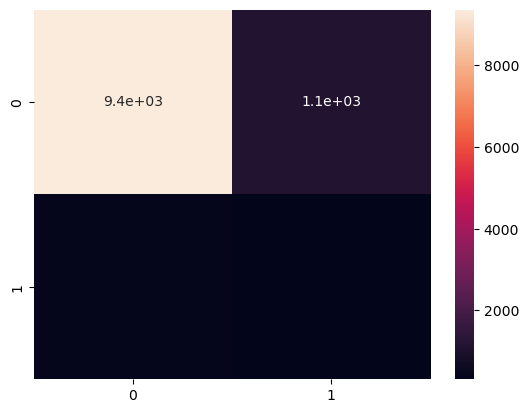

In [87]:
#scores = myModel.evaluate(lines_pad_x_test, Y_test, verbose=0)
#predictions = myModel.predict_classes(X_test, verbose=0)
predScores = myModel.predict(x_test)
predictions = (predScores > 0.5).astype("int32")

accuracy=accuracy_score(y_test, predictions)
if n_categories > 2:
    precision=precision_score(y_test, predictions, average='macro')
    recall=recall_score(y_test, predictions, average='macro')
    f1=f1_score(y_test, predictions, average='macro')
else:
    precision=precision_score(y_test, predictions)
    recall=recall_score(y_test, predictions)
    f1=f1_score(y_test, predictions)
    roc_auc=roc_auc_score(y_test, predictions)
f2=5*precision*recall / (4*precision+recall)

cm = confusion_matrix(y_test, predictions)
#print(cm)
sn.heatmap(cm, annot=True)
tn, fp, fn, tp = cm.ravel()

print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

acc = ((tp+tn)/(tp+tn+fp+fn))

print("Accuracy:%.2f%%"%(acc*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("F1 score:%.2f%%"%(f1*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F2 score:%.2f%%"%(f2*100))
print(classification_report(y_test, predictions))

In [88]:
# Create the path
path = os.path.join(root_path, 'results', userModel, method, str(seed))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{seed}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


In [92]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", userModel, method, str(seed))

for root, dirs, files in os.walk(results_folder):
    for filename in files:
        if filename.endswith(".csv") and filename != "avg.csv":
            csv_file_path = os.path.join(root, filename)

            with open(csv_file_path, "r", newline="") as csvfile:
                reader = csv.DictReader(csvfile)

                for row in reader:
                    for metric, value in row.items():
                        cumulative_metrics[metric] += float(value)
            count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", userModel, method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)

{'accuracy': 0.8646596390923709, 'precision': 0.2182952182952183, 'recall': 0.44871794871794873, 'f1': 0.29370629370629375, 'f2': 0.3705010585744531, 'roc_auc': 0.6706037322697636}
